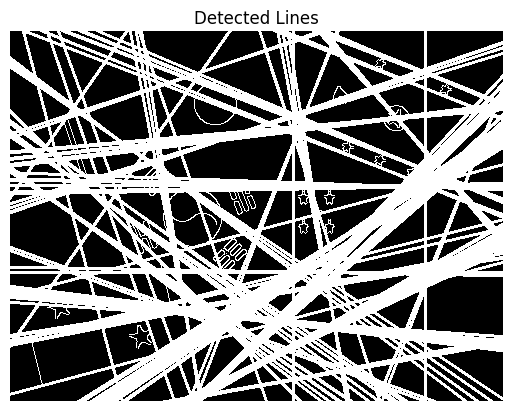

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time


def plot(image_name, image):
    time.sleep(0.75)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image_name)
    plt.show()


def get_threshold(image, sigma=0.23):
    v = np.median(image)
    lt = int(max(0, (1.0 - sigma) * v))
    ht = int(min(255, (1.0 + sigma) * v))
    return lt, ht


def detect_edges(image, low_threshold, high_threshold):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    #img = cv2.medianBlur(img, 5)
    th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    edges = cv2.Canny(th3, low_threshold, high_threshold)
    return edges


def build_images_dict():
    images_dict = {}

    # Several triangles example
    image = cv2.imread('group_signs/t_signs1.jpg')
    low_threshold, high_threshold = get_threshold(image)
    image_data = {'canny_low_threshold': low_threshold, 'canny_high_threshold': high_threshold,
                  'hough_min_theta': -np.pi / 2, 'hough_max_theta': np.pi / 2, 'ds_steps': 1,
                  'thetas_steps': np.pi / 180, 'edge_detection_threshold': 70, 'd_threshold': 10,
                  'theta_threshold': 0.2, 'window_shape': (150, 150), 'step_shape': (20, 20)}
    images_dict['several-triangles'] = (image, image_data)

    return images_dict


def remove_close_lines(lines, d_threshold, theta_threshold):
    suppressed_lines = []
    for rho, theta in lines:
        keep = True
        for r, t in suppressed_lines:
            if abs(rho - r) < d_threshold and abs(theta - t) < theta_threshold:
                keep = False
                break
        if keep:
            suppressed_lines.append((rho, theta))
    return suppressed_lines


def hough_transform(image_data, edges):
    height, width = edges.shape
    diagonal = int(np.sqrt(height ** 2 + width ** 2))

    ds = np.arange(-diagonal, diagonal, image_data['ds_steps'])
    thetas = np.arange(image_data['hough_min_theta'], image_data['hough_max_theta'], image_data['thetas_steps'])

    num_thetas = len(thetas)
    num_ds = len(ds)
    accumulator = np.zeros([num_ds, num_thetas], dtype=np.int64)
    voting_points = {}

    sins = np.sin(thetas)
    coss = np.cos(thetas)

    ys, xs = np.nonzero(edges)

    for x, y in zip(xs, ys):
        for t in range(num_thetas):
            current_d = int(x * coss[t] + y * sins[t])
            rho_pos = np.where(current_d > ds)[0][-1]
            accumulator[rho_pos, t] += 1
            line = (ds[rho_pos], thetas[t])
            if line not in voting_points:
                voting_points[line] = []
            voting_points[line].append((x, y))

    final_rho_index, final_theta_index = np.where(accumulator > image_data['edge_detection_threshold'])
    final_rho = ds[final_rho_index]
    final_theta = thetas[final_theta_index]

    lines = np.vstack([final_rho, final_theta]).T
    lines = remove_close_lines(lines, image_data['d_threshold'], image_data['theta_threshold'])
    return lines, accumulator, voting_points, ds, thetas


def draw_lines(image, lines):
    line_img = image.copy()
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + len(image[0]) * (-b))
        y1 = int(y0 + len(image[1]) * (a))
        x2 = int(x0 - len(image[0]) * (-b))
        y2 = int(y0 - len(image[1]) * (a))
        cv2.line(line_img, (x1, y1), (x2, y2), (255, 255, 255), 2)
    return line_img


def calculate_intersection(line1, line2):
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([rho1, rho2])
    if np.linalg.det(A) == 0:
        return None
    solution = np.linalg.solve(A, b)
    x, y = solution
    return int(x), int(y)


def find_intersections(lines, image_shape):
    """ Calculate intersections of all line pairs and store them in a dictionary. """
    intersections = {}
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            pt = calculate_intersection(lines[i], lines[j])
            if pt is not None:
                x, y = pt
                # Check if the intersection is within the bounds of the image
                if 0 <= x < image_shape[1] and 0 <= y < image_shape[0]:
                    # Store intersections in both possible orders to ensure easy lookup
                    intersections[(lines[i], lines[j])] = (x, y)
                    intersections[(lines[j], lines[i])] = (x, y)
    return intersections


def distance(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)


def angle(line1, line2):
    """ Calculate the angle in radians between two lines given in (rho, theta) format. """
    theta1, theta2 = line1[1], line2[1]
    angle = np.abs(theta1 - theta2)
    return angle if angle <= np.pi / 2 else np.pi - angle


def classify_triangle(pt1, pt2, pt3, line1, line2, line3):
    d1 = distance(pt1, pt2)
    d2 = distance(pt2, pt3)
    d3 = distance(pt3, pt1)
    angles = [
        angle(line1, line2),
        angle(line2, line3),
        angle(line3, line1)
    ]
    # Triangle inequality check
    if not (d1 + d2 > d3 and d2 + d3 > d1 and d3 + d1 > d2):
        return 'not a triangle'
    # Classify as right triangle if any angle is close to 90 degrees
    if any(np.isclose(ang, np.pi / 2, atol=0.01) for ang in angles):
        return 'right'
    # Equilateral triangle check (all sides approximately equal)
    elif np.isclose(d1, d2, atol=2) and np.isclose(d2, d3, atol=2) and np.isclose(d1, d3, atol=2) and all(
            np.isclose(ang, np.pi / 3, atol=0.1) for ang in angles):
        return 'equilateral'
    # Isosceles triangle check (at least two sides approximately equal)
    elif np.isclose(d1, d2, atol=2) or np.isclose(d2, d3, atol=2) or np.isclose(d3, d1, atol=2):
        return 'isosceles'
    else:
        return 'other'


def find_and_classify_triangles(intersections, lines):
    triangles = {'isosceles': [], 'right': [], 'equilateral': []}
    triangle_lines = {'equilateral': set(), 'isosceles': set(), 'right': set()}
    n = len(lines)

    for i in range(n):
        for j in range(i + 1, n):
            for k in range(j + 1, n):
                line1, line2, line3 = lines[i], lines[j], lines[k]
                if (line1, line2) in intersections and (line2, line3) in intersections and (
                        line3, line1) in intersections:
                    pt1 = intersections[(line1, line2)]
                    pt2 = intersections[(line2, line3)]
                    pt3 = intersections[(line3, line1)]
                    if pt1 != pt2 and pt2 != pt3 and pt3 != pt1:
                        triangle_type = classify_triangle(pt1, pt2, pt3, line1, line2, line3)
                        if triangle_type != 'other' and triangle_type != 'not a triangle':
                            triangles[triangle_type].append((pt1, pt2, pt3))
                            triangle_lines[triangle_type].add(line1)
                            triangle_lines[triangle_type].add(line2)
                            triangle_lines[triangle_type].add(line3)

    return triangles, triangle_lines


def color_edges_by_triangle(final_image, canny_edges, triangle_lines, voting_points, window_position):
    color_map = {
        'equilateral': (255, 0, 0),  # Blue
        'isosceles': (0, 255, 0),  # Green
        'right': (0, 0, 255),  # Red
    }
    height, width = canny_edges.shape
    x_offset, y_offset = window_position

    for triangle_type, lines in triangle_lines.items():
        for line in lines:
            points = voting_points[line]
            for x, y in points:
                if 0 <= y + y_offset < final_image.shape[0] and 0 <= x + x_offset < final_image.shape[1]:
                    final_image[y + y_offset, x + x_offset] = color_map[triangle_type]
                # Color neighbors if they are white
                for dy in range(-4, 5):  # Check a 10X10 neighborhood
                    for dx in range(-4, 5):
                        ny, nx = y + dy + y_offset, x + dx + x_offset
                        if (0 <= ny < final_image.shape[0] and 0 <= nx < final_image.shape[1] and
                                0 <= y + dy < height and 0 <= x + dx < width and
                                canny_edges[y + dy, x + dx] == 255):
                            final_image[ny, nx] = color_map[triangle_type]

    return final_image


def sliding_window(image, window_size, step_size):
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield x, y, image[y: min(y + window_size[1], image.shape[0]), x: min(x + window_size[0], image.shape[1])]


def draw_markers(image, lines, ds, thetas, color):
    for rho, theta in lines:
        rho_index = np.where(ds == rho)[0]
        theta_index = np.where(thetas == theta)[0]
        if rho_index.size > 0 and theta_index.size > 0:
            cv2.rectangle(image, (theta_index[0] - 2, rho_index[0] - 2), (theta_index[0] + 2, rho_index[0] + 2), color,
                          thickness=2, lineType=cv2.LINE_8)


# Sliding window parameters


images = build_images_dict()

# Initialize a list to store all the lines detected across all windows
all_lines = []

for img_name, img in images.items():
    print(f'{img_name} triangle detection')
    plot(f'{img_name} input image', img[0])

    canny_edges = detect_edges(img[0], img[1]['canny_high_threshold'], img[1]['canny_high_threshold'])
    plot(f'{img_name} edges map', canny_edges)

    final_image = cv2.cvtColor(canny_edges, cv2.COLOR_GRAY2BGR)

    for x, y, window in sliding_window(canny_edges, img[1]['window_shape'], img[1]['step_shape']):
        lines, accumulator, voting_points, ds, thetas = hough_transform(img[1], window)

        # Adjust the lines' coordinates based on the window position
        adjusted_lines = []
        for rho, theta in lines:
            rho_adj = rho + (x * np.cos(theta) + y * np.sin(theta))
            adjusted_lines.append((rho_adj, theta))

        # Accumulate adjusted lines
        all_lines.extend(adjusted_lines)

        intersections = find_intersections(lines, window.shape)

        triangles, triangle_lines = find_and_classify_triangles(intersections, lines)

        norm_accumulator = cv2.normalize(accumulator, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        norm_accumulator = cv2.cvtColor(norm_accumulator, cv2.COLOR_GRAY2BGR)
        # Draw markers for different types of triangle sides
        draw_markers(norm_accumulator, triangle_lines['equilateral'], ds, thetas, (255, 0, 0))  # Blue for equilateral
        draw_markers(norm_accumulator, triangle_lines['isosceles'], ds, thetas, (0, 255, 0))  # Green for isosceles
        draw_markers(norm_accumulator, triangle_lines['right'], ds, thetas, (0, 0, 255))  # Red for right

        if any(len(triangle_list) > 0 for triangle_list in triangles.values()):
            final_image = color_edges_by_triangle(final_image, window, triangle_lines, voting_points, (x, y))

    # Draw all the lines accumulated across all windows
    lines_img = draw_lines(canny_edges.copy(), all_lines)
    plot(f'{img_name} detected lines', lines_img)

    plot(f'{img_name} Detected triangles (color-coded)', final_image)
